### Example on workflow for trainable parameter optimization of quantum kernels

Exemplary shown for:

- Fidelity Quantum Kernel
- simple 1D regression problem
- Optimization of NLL based on ADAM optimizer
- QGPR for solving the final regression problem

In [1]:
# necessary imports
import numpy as np

from squlearn.util import Executor
from squlearn.encoding_circuit import ChebyshevPQC
from squlearn.kernel import FidelityKernel
from squlearn.kernel import QGPR
from squlearn.kernel.matrix.kernel_optimizer import KernelOptimizer
from squlearn.kernel.optimization import NLL

In [2]:
# Generate training data.
def func(x):
    return np.sin(3 * x) * x * x


noise_std = 0.1
X_test = np.linspace(-1, 1, 100)
Y_test = func(X_test)
X_train = np.linspace(-1, 1, 15)
Y_train = func(X_train) + np.random.normal(scale=noise_std, size=len(X_train))

In [3]:
# set up fidelity quantum kernel
num_qubits = 4
enc_circ = ChebyshevPQC(num_qubits, num_features=1, num_layers=2)
q_kernel = FidelityKernel(
    encoding_circuit=enc_circ, executor=Executor("pennylane"), parameter_seed=0
)

In [4]:
# set up the optimizer, the usage of NLL as loss functoin as well as initialiing the KernelOptimizer
from squlearn.optimizers import Adam

adam = Adam(options={"maxiter": 20, "lr": 0.1})
nll_loss = NLL(quantum_kernel=q_kernel, sigma=noise_std**2)
kernel_optimizer = KernelOptimizer(quantum_kernel=q_kernel, loss=nll_loss, optimizer=adam)

<i>Note:</i> The following cell takes approx. 20s to finish

In [5]:
# Set up the QGPR with the KernelOptimizer to perform the kernel optimization automatically when the fit is called
qgpr_model = QGPR(quantum_kernel=kernel_optimizer, sigma=noise_std**2)
qgpr_model.fit(X_train.reshape(-1, 1), Y_train)
qgpr_mean, qgpr_std = qgpr_model.predict(X_test.reshape(-1, 1), return_std=True)

Text(0, 0.5, '$f(x)$')

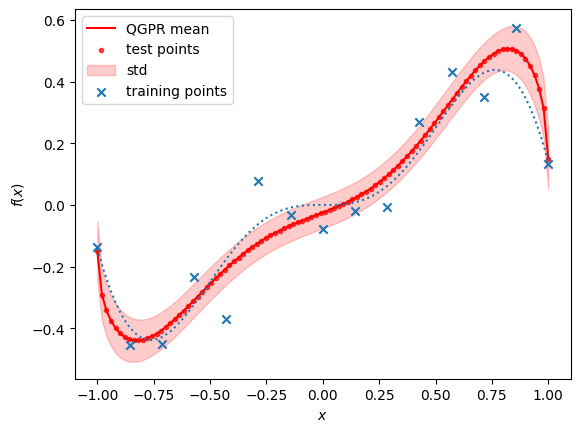

In [6]:
from matplotlib import pyplot as plt

# plot result
plt.plot(X_test.reshape(-1, 1), qgpr_mean, color="red", label="QGPR mean")
plt.scatter(
    X_test.reshape(-1, 1), qgpr_mean, marker=".", label="test points", color="red", alpha=0.7
)
plt.fill_between(
    X_test.reshape(-1),
    qgpr_mean.reshape(-1) - qgpr_std,
    qgpr_mean.reshape(-1) + qgpr_std,
    color="red",
    label="std",
    alpha=0.2,
)
plt.scatter(X_train, Y_train, marker="x", label="training points")
plt.plot(X_test, Y_test, linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")